In [1]:
# Import all the Dependencies
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score

In [2]:
#Set all the Constants
BATCH_SIZE = 32
IMAGE_SIZE = 224
CHANNELS=3
EPOCHS=100

In [4]:
#import data into tensorflow dataset object
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "C:/Users/Syed Issam Bukhari/Documents/projects all/projects/skin cancer/skin",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 3297 files belonging to 2 classes.


In [5]:

class_names = dataset.class_names
class_names

['benign', 'malignant']

In [6]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 224, 224, 3)
[1 0 1 0 1 1 0 1 0 0 0 0 0 1 0 1 0 1 0 0 1 1 1 0 1 0 1 0 0 1 1 0]


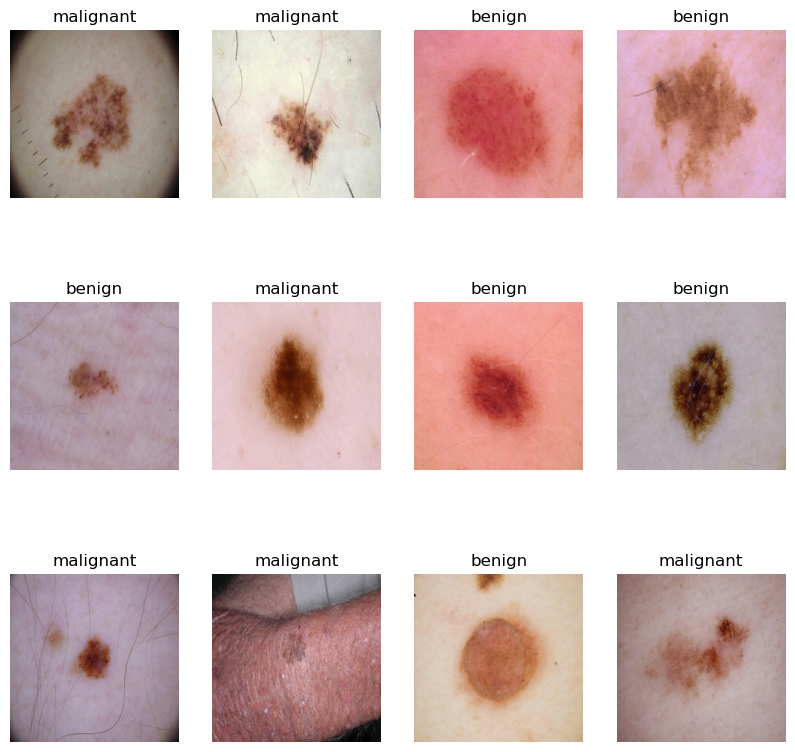

In [7]:
#Visualize some of the images from our dataset
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [8]:
#Function to Split Dataset
len(dataset)

104

In [9]:
train_size = 0.8
len(dataset)*train_size

83.2

In [10]:
train_ds = dataset.take(54)
len(train_ds)

54

In [11]:
test_ds = dataset.skip(54)
len(test_ds)

50

In [12]:
val_size=0.1
len(dataset)*val_size

10.4

In [13]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [14]:
test_ds = test_ds.skip(6)
len(test_ds)

44

In [15]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [16]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [17]:
len(train_ds)

83

In [18]:
len(val_ds)

10

In [19]:
len(test_ds)

11

In [20]:
#Cache, Shuffle, and Prefetch the Dataset
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:
#Building the Model
#Creating a new Layer for Resizing and Normalization
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./244),
])

In [22]:
#Data Augmentation
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [23]:
#Applying Data Augmentation to Train Dataset
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [25]:
#Model Architecture
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [26]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 224, 224, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 222, 222, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 111, 111, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (32, 109, 109, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (32, 54, 54, 64)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (32, 52, 52, 64)         

In [27]:
#Compiling the Model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [28]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=100,
)

Epoch 1/100
83/83 [==============================] - 162s 2s/step - loss: 0.6381 - accuracy: 0.6152 - val_loss: 0.5462 - val_accuracy: 0.6906
Epoch 2/100
83/83 [==============================] - 146s 2s/step - loss: 0.5043 - accuracy: 0.7520 - val_loss: 0.4493 - val_accuracy: 0.7656
Epoch 3/100
83/83 [==============================] - 146s 2s/step - loss: 0.4726 - accuracy: 0.7623 - val_loss: 0.4923 - val_accuracy: 0.7719
Epoch 4/100
83/83 [==============================] - 144s 2s/step - loss: 0.4937 - accuracy: 0.7596 - val_loss: 0.4431 - val_accuracy: 0.7750
Epoch 5/100
83/83 [==============================] - 144s 2s/step - loss: 0.4512 - accuracy: 0.7680 - val_loss: 0.4454 - val_accuracy: 0.7688
Epoch 6/100
83/83 [==============================] - 145s 2s/step - loss: 0.4414 - accuracy: 0.7817 - val_loss: 0.3994 - val_accuracy: 0.8000
Epoch 7/100
83/83 [==============================] - 143s 2s/step - loss: 0.4406 - accuracy: 0.7771 - val_loss: 0.4505 - val_accuracy: 0.7500
Epoch 

83/83 [==============================] - 124s 1s/step - loss: 0.3193 - accuracy: 0.8495 - val_loss: 0.2700 - val_accuracy: 0.8813
Epoch 59/100
83/83 [==============================] - 122s 1s/step - loss: 0.3066 - accuracy: 0.8522 - val_loss: 0.2635 - val_accuracy: 0.8781
Epoch 60/100
83/83 [==============================] - 123s 1s/step - loss: 0.2985 - accuracy: 0.8552 - val_loss: 0.2551 - val_accuracy: 0.8844
Epoch 61/100
83/83 [==============================] - 123s 1s/step - loss: 0.3173 - accuracy: 0.8510 - val_loss: 0.2848 - val_accuracy: 0.8562
Epoch 62/100
83/83 [==============================] - 123s 1s/step - loss: 0.3465 - accuracy: 0.8331 - val_loss: 0.3471 - val_accuracy: 0.8219
Epoch 63/100
83/83 [==============================] - 123s 1s/step - loss: 0.3248 - accuracy: 0.8453 - val_loss: 0.2736 - val_accuracy: 0.8813
Epoch 64/100
83/83 [==============================] - 126s 2s/step - loss: 0.3086 - accuracy: 0.8480 - val_loss: 0.3186 - val_accuracy: 0.8406
Epoch 65/100

In [30]:
#Plotting the Accuracy and Loss Curves
history

In [31]:
history.params

{'verbose': 1, 'epochs': 100, 'steps': 83}

In [32]:
history.history.keys()
#loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [33]:
type(history.history['loss'])

list

In [34]:
len(history.history['loss'])

100

In [35]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.6381293535232544,
 0.5042770504951477,
 0.4725952446460724,
 0.4936940670013428,
 0.45121511816978455]

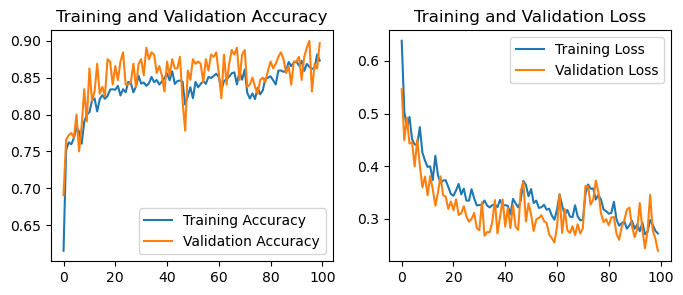

In [55]:
plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

first image to predict
actual label: malignant
1/1 [==============================] - 1s 657ms/step
predicted label: malignant


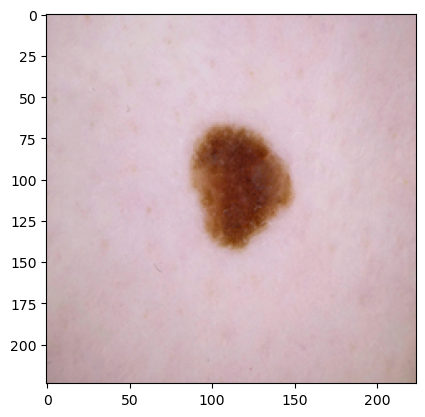

In [37]:
#Run prediction on a sample image
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [38]:
#Write a function for inference
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 39ms/step


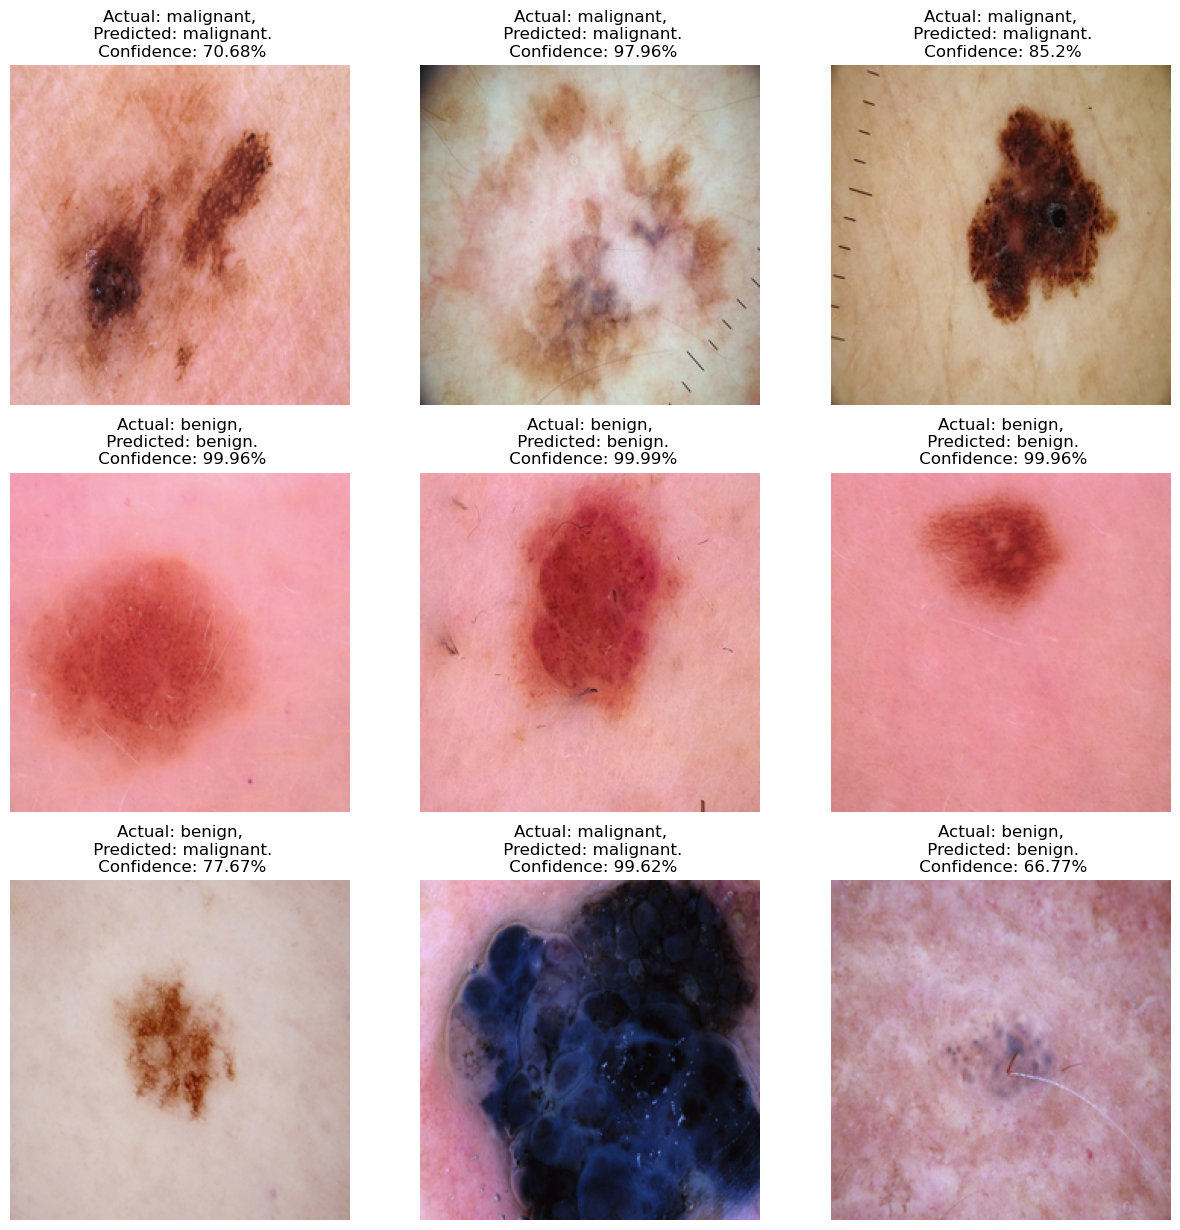

In [39]:
#Now run inference on few sample images
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [40]:
scores = model.evaluate(test_ds)

11/11 [==============================] - 4s 399ms/step - loss: 0.2517 - accuracy: 0.8864


In [41]:
#You can see above that we get 97.00% accuracy for our test dataset. This is considered to be a pretty good accuracy
scores
#Score is just a list containing loss and accuracy value

[0.25174859166145325, 0.8863636255264282]

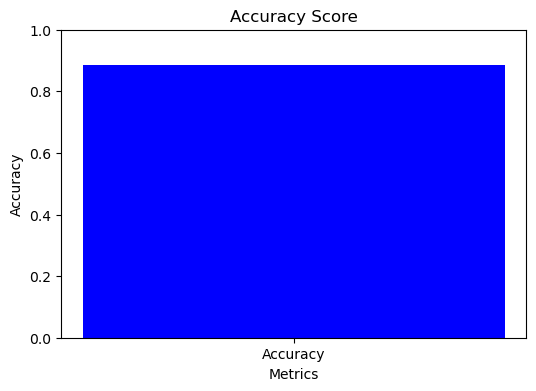

In [42]:

# Plotting the Accuracy Score
plt.figure(figsize=(6, 4))
plt.bar(["Accuracy"], [scores[1]], color='blue')
plt.ylim(0, 1)  # Set the y-axis limit from 0 to 1
plt.xlabel("Metrics")
plt.ylabel("Accuracy")
plt.title("Accuracy Score")
plt.show()


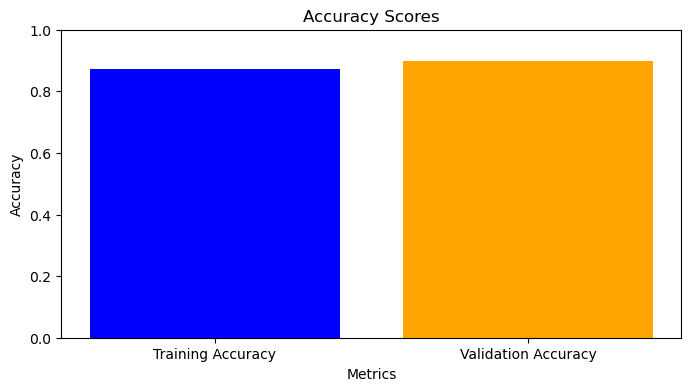

In [43]:
# Plotting the Accuracy Scores
plt.figure(figsize=(8, 4))
metrics = ["Training Accuracy", "Validation Accuracy"]
accuracy_scores = [acc[-1], val_acc[-1]]

plt.bar(metrics, accuracy_scores, color=['blue', 'orange'])
plt.ylim(0, 1)  # Set the y-axis limit from 0 to 1
plt.xlabel("Metrics")
plt.ylabel("Accuracy")
plt.title("Accuracy Scores")
plt.show()


1/1 [==============================] - 1s 512ms/step


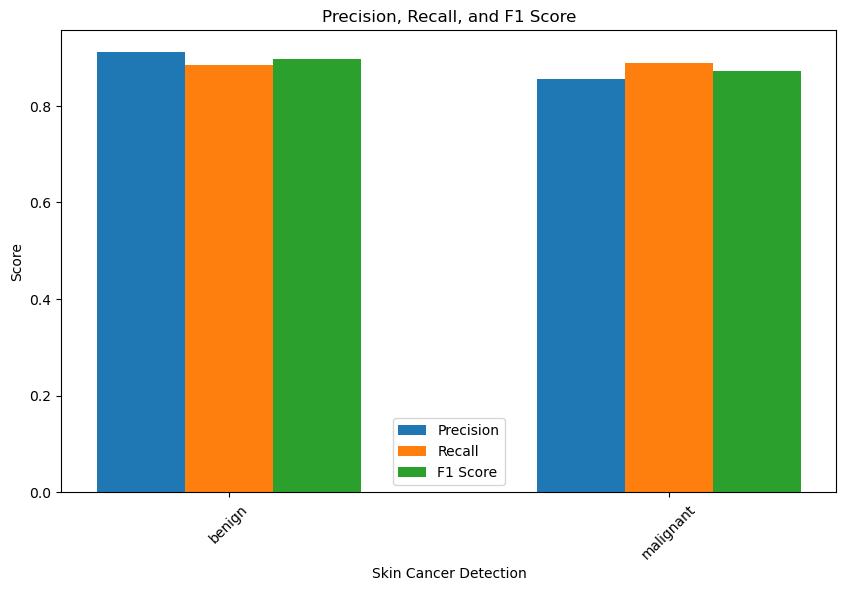

In [48]:

# Printing Precision, Recall, and F1 Score
test_images = []
test_labels = []
predicted_labels = []

for images_batch, labels_batch in test_ds:
    test_images.extend(images_batch.numpy())
    test_labels.extend(labels_batch.numpy())
    batch_prediction = model.predict(images_batch)
    predicted_labels.extend(np.argmax(batch_prediction, axis=1))

test_labels = np.array(test_labels)
predicted_labels = np.array(predicted_labels)

precision = precision_score(test_labels, predicted_labels, average=None)
recall = recall_score(test_labels, predicted_labels, average=None)
f1 = f1_score(test_labels, predicted_labels, average=None)

# Plotting the metrics
plt.figure(figsize=(10, 6))
x = np.arange(len(class_names))

plt.bar(x - 0.2, precision, width=0.2, label='Precision')
plt.bar(x, recall, width=0.2, label='Recall')
plt.bar(x + 0.2, f1, width=0.2, label='F1 Score')

plt.xticks(x, class_names, rotation=45)
plt.xlabel('Skin Cancer Detection')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Score')
plt.legend()
plt.show()


1/1 [==============================] - 0s 496ms/step


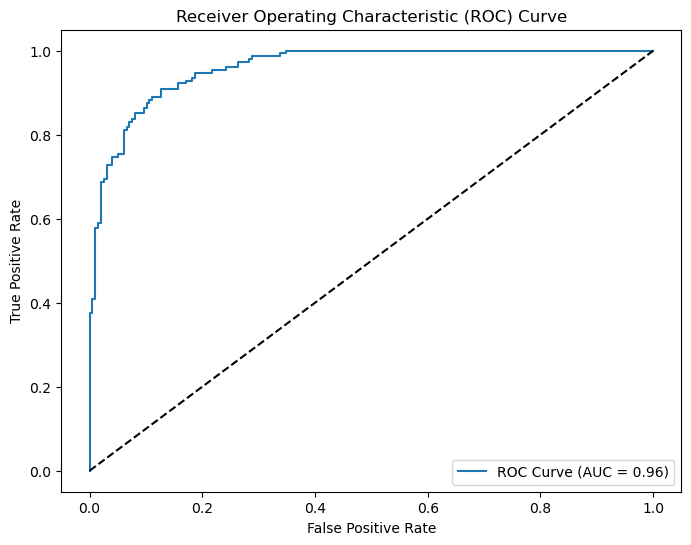

AUC Score: 0.9595303686212777


In [49]:
# After evaluating the model on the test set
test_images = []
test_labels = []
predicted_probabilities = []

for images_batch, labels_batch in test_ds:
    test_images.extend(images_batch.numpy())
    test_labels.extend(labels_batch.numpy())
    batch_prediction = model.predict(images_batch)
    predicted_probabilities.extend(batch_prediction)

test_labels = np.array(test_labels)
predicted_probabilities = np.array(predicted_probabilities)

# Calculate the ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(test_labels, predicted_probabilities[:, 1])
auc_score = roc_auc_score(test_labels, predicted_probabilities[:, 1])

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(auc_score))
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Print the AUC score
print('AUC Score:', auc_score)


In [44]:
#Saving the Model
model.save("skin88.h5")

In [45]:
#Saving the Model
model.save("97accur.pb")

INFO:tensorflow:Assets written to: 97accur.pb\assets


INFO:tensorflow:Assets written to: 97accur.pb\assets
